<a href="https://colab.research.google.com/github/manuelurgell/TC4034.10-Equipo18/blob/main/Copie_2_de_implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing required dependencies

!pip install fuzzywuzzy
!pip install implicit
!pip install surprise
!pip install fastFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357252 sha256=44afbfbf736ba80bc24c0cb6c6dbc0c39cdb7819f86acbadf29635a7f1e269e1
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastFM: filename=fastFM-0.2.10-cp310-cp310-linux_x86_64.whl size=591642 sha256=9ebc3840ffe5a805383c73b55333307fd745c721e97b888d55b2b352767f568f
  Stored in directory: /root/.cache/pip/wheels/93/92/52/2da7997fcb7a7ce9042ff3b33836ef0c2fd47aa9

In [ ]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

# Matrix operator
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# 1 ALS
from implicit.als import AlternatingLeastSquares

# 2. SVD
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# 3. Modelos de Factorización de Matrices No Negativas (NMF)
from sklearn.decomposition import NMF

# 4. Bayesian Personalized Ranging (BPR)
from implicit.bpr import BayesianPersonalizedRanking

# 5.  Factorization Machines (FM)
from fastFM import als

# accesing into google colab file
from google.colab import drive

### Loading data

In [ ]:
# mounting content drive
drive.mount('/content/drive')
# route file
root_file_path = '/content/drive/My Drive/3 trimestre/Big data/beer_reviews.csv'
# dataframe
df = pd.read_csv(root_file_path)
# show the first rows
df.head()

Mounted at /content/drive


,index,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


### Data transformation

In [ ]:
beers_df = df[['beer_name','beer_beerid',  'review_profilename', 'review_overall']]
beers_df.dropna()
beers_df = beers_df.drop_duplicates()
beers_df['review_profilename'] = beers_df['review_profilename'].astype(str)
beers_df['review_profilename'] = beers_df['review_profilename'].str.lower().str.strip()

print(beers_df.shape)
beers_df.head()


<ipython-input-4-71c52bfdc63e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beers_df['review_profilename'] = beers_df['review_profilename'].astype(str)


(1580453, 4)


,beer_name,beer_beerid,review_profilename,review_overall
0,Sausa Weizen,47986,stcules,1.5
1,Red Moon,48213,stcules,3.0
2,Black Horse Black Beer,48215,stcules,3.0
3,Sausa Pils,47969,stcules,3.0
4,Cauldron DIPA,64883,johnmichaelsen,4.0


In [ ]:
beers_df['review_overall'].agg(['max', 'min'])

max    5.0
min    0.0
Name: review_overall, dtype: float64

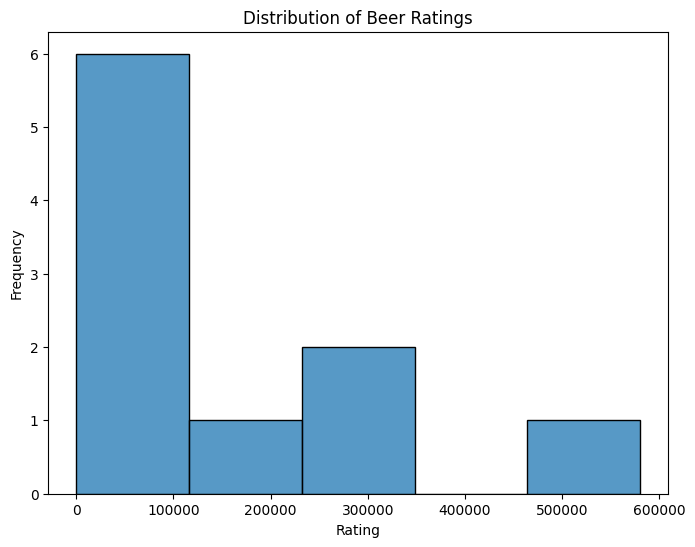

In [ ]:
plt.figure(figsize=(8,6))
distBeersRatings = beers_df['review_overall'].value_counts().sort_index(ascending=False)
sns.histplot(distBeersRatings.T)
plt.title('Distribution of Beer Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
#plt.xticks(range(1,6))
plt.show()

In [ ]:
distByBeer = beers_df.groupby('beer_name')['review_overall'].count().clip(upper=50)
distByBeer

beer_name
! (Old Ale)                         1
"100"                               5
"100" Pale Ale                      1
"12"  Belgian Golden Strong Ale     2
"33" Export                         3
                                   ..
Žamberecký Kanec Imperial Stout    2
Ω-naught (Omeganaught)              3
“Chewy” Double IPA                  1
横須賀ビアサケ (Yokosuka Biasake)          1
葉山ビール (Hayama Beer)                 1
Name: review_overall, Length: 56857, dtype: int64

### 1. Alternating Least Squares algorithm

1.   List item
2.   List item



__algorithm to factorize a matrix.__

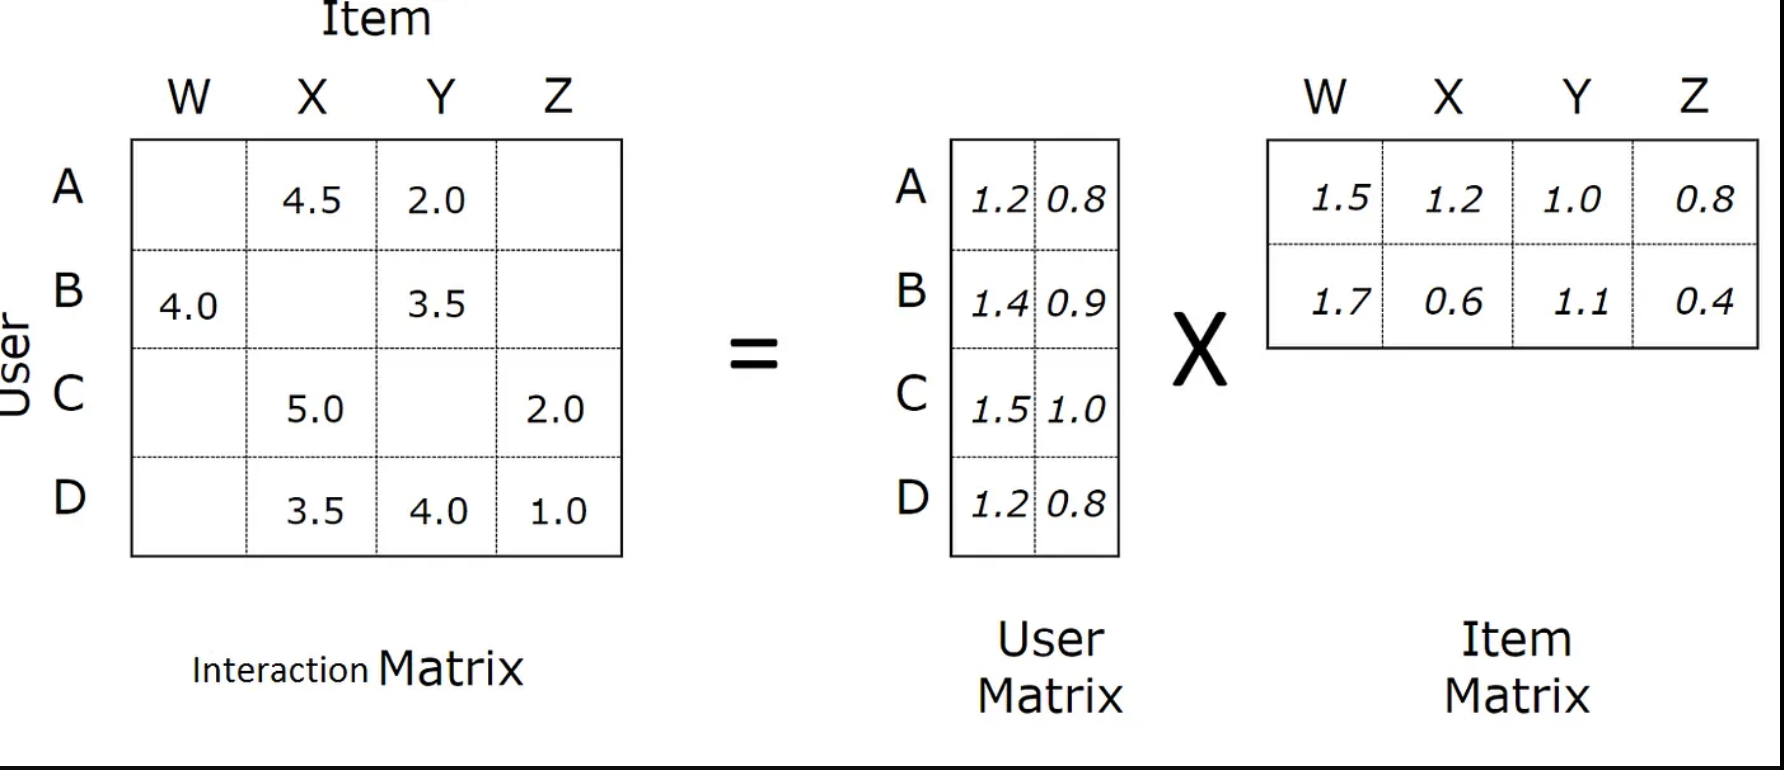






As in the previous figure, that a matrix being factorized into 2 smaller matrices.


first matrix as the set of user-item interactions

second matrix as  item features

The interaction matrix values are events which has specific preferences and confidence which give the value of the each element


__preference__

__confidence__



csr_matrix: Compressed Sparse Row matrix
when it comes to matrix operations such as multiplication or inversion, the CSC or CSR sparse matrix format is more suitable and efficient. The csc_matrix has faster column slicing, while the csr_matrix has faster row slicing, owing to the data structure


In [ ]:
def create_X(beer_df: pd.DataFrame):

  N = beer_df['review_profilename'].nunique();
  M = beer_df['beer_beerid'].nunique()



  user_mapper = dict(zip(np.unique(beer_df['review_profilename']), list(range(N))))
  item_mapper = dict(zip(np.unique(beer_df['beer_beerid']), list(range(M))))


  user_inv_mapper = dict(zip(list(range(N)), np.unique(beer_df['review_profilename'])))
  item_inv_mapper = dict(zip(list(range(N)), np.unique(beer_df['beer_beerid'])))


  user_index = [user_mapper[user] for user in beer_df['review_profilename']]
  item_index = [item_mapper[item] for item in beer_df['beer_beerid']]

  #creating interactions matrix item x user
  sparse_item_user = csr_matrix((beer_df['review_overall'], (item_index, user_index)), shape=(M, N))

  return sparse_item_user, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper, N, M

sparse_item_user, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper, N, M = create_X(beers_df)

In [ ]:
#items = beers_df.drop_duplicates('beer_name', keep='first').set_index('beer_name')['beer_beerid'].to_dict()
#items_inv = beers_df.drop_duplicates('beer_name', keep='first').set_index('beer_beerid')['beer_name'].to_dict()

unique_items = beers_df.groupby('beer_name').first().reset_index()
items = unique_items.set_index('beer_name')['beer_beerid'].to_dict()
item_inv = unique_items.set_index('beer_beerid')['beer_name'].to_dict()

In [ ]:
print(items['Red Moon'])

48213


In [ ]:
def beer_finder(beer_name):
  all_beers = items.keys()
  closest_match = process.extractOne(beer_name, all_beers)
  return closest_match[0]

def get_beer_index(beer_name):
  fuzzy_beer = beer_finder(beer_name)
  beer_idx = items[beer_name]
  return beer_idx

def get_beer_name(beer_idx):
  try:
    beer_name = items_inv[beer_idx]
    return beer_name
  except:
    return None


In [ ]:
beer_finder('Red Moon')

'Red Moon'

In [ ]:
get_beer_index('Deuane')

56901

In [ ]:
get_beer_name(5050)

'Dojlidy Zubr'

In [ ]:
model = AlternatingLeastSquares(factors=50)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [ ]:
model.fit(sparse_item_user.T.tocsr())

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
beer_of_interest = 'Dojlidy Zubr'
beer_idx = get_beer_index(beer_of_interest)
related = model.similar_items(beer_idx)
related

(array([ 5050,  8718,  9349, 18308,  6573, 14876,  7937,  8719,  7939,
        15297], dtype=int32),
 array([0.99999994, 0.8768723 , 0.8497387 , 0.83988863, 0.83793384,
        0.8308235 , 0.8279407 , 0.8221166 , 0.81347936, 0.811385  ],
       dtype=float32))

In [ ]:
print(f'because you liked {beer_of_interest} beer, it could be possible that you would be interested into:')
for t, r in zip(related[0], related[1]):
  recommended_beer = get_beer_name(t)
  if(recommended_beer):
    print(recommended_beer)

because you liked Dojlidy Zubr beer, it could be possible that you would be interested into:
Dojlidy Zubr
Black Forest Blue Star
Stoney Creek Doppelbock
Skol Beats
Baltika #12 Novogodneye
Dojlidy Mocne Special Beer


In [ ]:
user_name = 'johnmichaelsen'
user_ratings = beers_df[beers_df['review_profilename'] == user_name]
user_ratings = user_ratings.sort_values('review_overall', ascending=False)
print(f'No. Ranked beers {user_ratings.beer_name.nunique()} by user {user_name}')

No. Ranked beers 1959 by user johnmichaelsen


In [ ]:
top_5 = user_ratings.head()
top_5

,beer_name,beer_beerid,review_profilename,review_overall
1366496,Lagunitas IPA,916,johnmichaelsen,5.0
1387731,X,33066,johnmichaelsen,5.0
1143819,Redemption,13741,johnmichaelsen,5.0
880201,Stone Imperial Russian Stout,1160,johnmichaelsen,5.0
99909,Abbaye De Saint Bon-Chien Grand Cru (Aged In P...,47600,johnmichaelsen,5.0


In [ ]:
bottom_5 = user_ratings[user_ratings['review_overall'] < 5].tail()
bottom_5

,beer_name,beer_beerid,review_profilename,review_overall
1305142,Bud Light Lime,41821,johnmichaelsen,1.5
324621,Pabst Blue Ribbon (PBR),1331,johnmichaelsen,1.0
666665,Landshark Lager,34804,johnmichaelsen,1.0
1301285,Bud Light,1320,johnmichaelsen,1.0
1305588,Budweiser Select 55,52480,johnmichaelsen,1.0


In [ ]:
X_t = sparse_item_user.T.tocsr()
user_idx = user_mapper[user_name]
recommendation_to_user = model.recommend(user_idx, X_t[user_idx], N=10)
recommendation_to_user

(array([54679, 47831, 33505,   116, 34506, 13310, 27934, 17530, 60021,
        41338], dtype=int32),
 array([1.5849925, 1.5231572, 1.3381699, 1.2662685, 1.2530714, 1.2476361,
        1.245225 , 1.2420716, 1.2403725, 1.2292434], dtype=float32))

In [ ]:
for t, r in zip(recommendation_to_user[0], recommendation_to_user[1]):
  recommended_beer_to = get_beer_name(t)
  if(recommended_beer_to):
    print(f'{recommended_beer_to}: {r}')

Günther Bräu Edles Lagerbier: 1.584992527961731
Swift One: 1.5231572389602661
Pisser Mauvais: 1.3381699323654175
Jack Whacker Wheat Ale: 1.2662684917449951
Lee's Choice Oatmeal Stout: 1.2530714273452759
Elevator Chocolate Stout: 1.245224952697754
Osprey Ale: 1.2420716285705566
Pumphouse Copper: 1.2403725385665894


https://medium.com/@eng.saavedra/sistemas-de-recomendaci%C3%B3n-parte-4-evaluaciones-cfd1f96b887a

In [ ]:
als_y_true = X_t[user_idx].toarray().flatten()
als_y_pred = np.zeros_like(als_y_true)

for tmp_item_id, als_score in zip(recommendation_to_user[0], recommendation_to_user[1]):
  als_y_pred[tmp_item_id] = als_score

rmse = np.sqrt(mean_squared_error(als_y_true, als_y_pred))
print(f'rmse {rmse}')

rmse 0.7207915608019735


### 2. SVD
for this algorithm of recommendation we use Scikit-surprise that is a library specialized for recommendations systems




> https://proceedings.neurips.cc/paper_files/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf



In [ ]:
#preparing data into surprise library
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(beers_df[['review_profilename', 'beer_beerid', 'review_overall']], reader)

# train and test set
train_set, test_set = train_test_split(data_surprise, test_size=0.20)

#training model
model_svd = SVD()
model_svd.fit(train_set)

#predictions and evaluation
svd_predictions = model_svd.test(test_set)
accuracy.rmse(svd_predictions)

RMSE: 0.6085


0.6084854163893528

In [ ]:
#prediction to an specifique user
svd_recommendations = []
for item_id in beers_df['beer_beerid'].unique():
  pred = model_svd.predict(user_name, item_id).est
  svd_recommendations.append((item_id, pred))

In [ ]:
#showing recommendations
svd_recommendations.sort(key=lambda x: x[1], reverse=True)
print(f'SVD recommendations for user {user_name}: \n')
for item_id, score in svd_recommendations[:10]:
  print(item_id)
  print(f'Beer {item_inv[item_id]}: {score}')

SVD recommendations for user johnmichaelsen: 

63649
Beer Rare D.O.S.: 4.873562605845315
68548
Beer Armand'4 Oude Geuze Lente (Spring): 4.845222128054847
44910
Beer Dirty Horse: 4.791623470688369
58610
Beer Hoppy Birthday: 4.773026895951584
21625
Beer Mönchsambacher Lager: 4.737674044416177
23413
Beer Geuze Cuvée J&J (Joost En Jessie) Blauw (Blue): 4.737451434360769
70356
Beer Armand'4 Oude Geuze Zomer (Summer): 4.733347054324431
61100
Beer King Henry: 4.696882178674115
39238
Beer 32/50: 4.686330415907984
65229
Beer Bourbon Barrel Aged Hi-Fi Rye: 4.676627138451204


### 3. Modelos de Factorización de Matrices No Negativas (NMF)




In [ ]:
model_nmf = NMF(n_components=70, max_iter=100)

In [ ]:
user_factors = model_nmf.fit_transform(sparse_item_user)
item_factors = model_nmf.components_

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
user_ratings_pred = user_factors[user_mapper[user_name]].dot(item_factors)

In [ ]:
top_items_indices = user_ratings_pred.argsort()[::-1]

In [ ]:
print(f'NMF recommendations for user {user_name}')
for idx in top_items_indices[:10]:
  try:
    print(f'Beer {item_inv[idx]}: {user_ratings_pred[idx]}')
  except:
    print('not found ', idx)

NMF recommendations for user johnmichaelsen
Beer Sheagal Herb And Spice: 3.7413363150645838
Beer Hunter Kolsch: 0.5073869135324005
Beer Dark-Toberfest: 0.4147641383775501
Beer Grain Belt Premium: 0.399631963880683
Beer Mainland Lager: 0.3536853098420032
Beer Bourbon Cask Aged Wheat Trippelbock: 0.3112471680924593
Beer Aprihop Wheat: 0.29696967140257063
Beer Bug Light: 0.28359881310150736
Beer Urbanus Premium Hell: 0.2783817455718853
Beer North Star Red: 0.2613188566316605


In [ ]:
user_ratings_act = sparse_item_user[user_mapper[user_name]].toarray().squeeze()
#print(len(user_ratings_act), len(user_ratings_pred))
rmse_nmf = np.sqrt(mean_squared_error(user_ratings_act, user_ratings_pred))
print(rmse_nmf)

0.06290891870559161


### 4. Bayesian Personalized Ranking (BPR) for implicit feedback

build a matrix __U__ (#items × #items) for the preferences of user __u__.

If a user clicked the item _i_ but didn’t click the item _j_, U<sub>[i][j]</sub> is positive, and U<sub>[j][i]</sub> is negative. If the user clicked both or neither of them, then we don’t assign any value to both U<sub>[i][j]</sub> and U<sub>[j][i]</sub>.

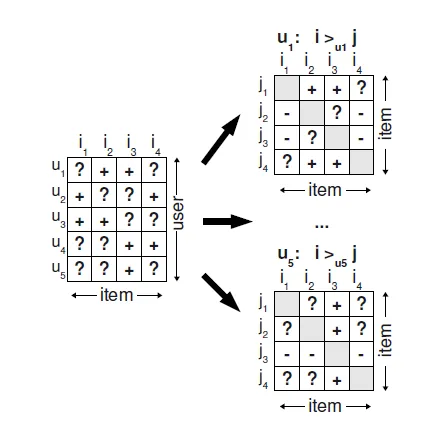


> Ajouter une citation
https://medium.com/@radleaf/bpr-and-recommendation-system-3d9a3975c132


BPR consists of the optimization criterion BPR-P`t and the algorithm learnBPR for the optimization

In [ ]:
model_bpr = BayesianPersonalizedRanking(factors=50, regularization=0.1, iterations=20)

In [ ]:
model_bpr.fit(sparse_item_user.T)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.03152656555175781 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
user_idx = user_mapper[user_name]
X_t = sparse_item_user.T.tocsr()

bpr_recommendations = model_bpr.recommend(user_idx, X_t[user_idx], N=10)
bpr_recommendations

(array([37191, 18187, 40254, 40323, 33761, 55419,   602, 27210, 50626,
        41634], dtype=int32),
 array([0.6671962 , 0.6309613 , 0.58339   , 0.5788459 , 0.5766017 ,
        0.54224133, 0.5298073 , 0.525114  , 0.50342345, 0.49571604],
       dtype=float32))

In [ ]:
print(f'BPR Recommendations for :{user_name}')
for t, r  in zip(bpr_recommendations[0], bpr_recommendations[1]):
  recommended_beer_to = get_beer_name(t)
  if(recommended_beer_to):
    print(f'{recommended_beer_to}: {r}')
  else:
    print(f'not found beer_id[{t}] {r}')

BPR Recommendations for :johnmichaelsen
Samsquanch: 0.6671962141990662
A. Le Coq Double Bock: 0.6309612989425659
St Petersburg Christmas: 0.5833899974822998
Standard Pioneer: 0.5788459181785583
Red Cream: 0.5766016840934753
not found beer_id[55419] 0.5422413349151611
Caledonian 80/-: 0.5298073291778564
German Style Wheat Beer: 0.5251139998435974
not found beer_id[50626] 0.5034234523773193
Bardstown Brand Ale Aged In Bourbon Barrels: 0.49571603536605835


In [ ]:
bpr_y_true = X_t[user_idx].toarray().flatten()
bpr_y_pred = np.zeros_like(bpr_y_true)

for bpr_item_id, bpr_score in zip(recommendation_to_user[0], recommendation_to_user[1]):
  bpr_y_pred[bpr_item_id] = als_score

rmse = np.sqrt(mean_squared_error(bpr_y_true, bpr_y_pred))
print(f'rmse: {rmse}')

rmse: 0.7207665075375183
